In [4]:
%matplotlib widget

import numpy as np
import os
from scipy import spatial, stats
import matplotlib.pyplot as plt
from spacer3d.Ripley import load_OIB, load_mask, load_tumor_locations, run_ripley, monte_carlo, set_aspect_ratio_equal

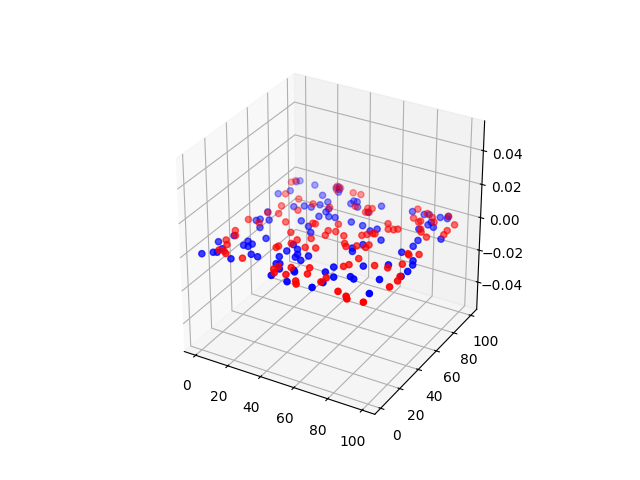

In [12]:
test_set1 = stats.uniform.rvs(loc=0, scale=100, size=(100,2))
test_set2 = stats.uniform.rvs(loc=0, scale=100, size=(100,2))
test_mask = np.ones((100, 100))
test_radii = np.arange(2, 50)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
set_aspect_ratio_equal(ax)
ax.scatter(test_set1[:, 1],test_set1[:, 0], color="#f00",marker="o", depthshade=True)
ax.scatter(test_set2[:, 1],test_set2[:, 0], color="#00f",marker="o", depthshade=True)




In [13]:
# Univariate analysis compares a set of points against itself
test_results = run_ripley(test_set1, test_set1, test_mask, test_radii, n_processes=1)

ValueError: Expected self.points_i array to have shape (None, 3), but got array with shape (100, 2)

### Loading real data pointsets for comparison

In [ ]:
### Loading Confocal Image (.OIB)
path = "/data/dkermany_data/Bone_Project/FV10__oibs/FV10__20190620_111343.oib"
filename = os.path.splitext(os.path.basename(path))[0]

# step sizes to convert tumor micron locations to pixel
steps = (0.621, 0.621, 3.14) if filename=="FV10__20210112_164055" else (1.242, 1.242, 2.66)

# filename, viewer, steps = load_OIB(path)

In [ ]:
### Loading 3D Binary Mask (.SEG.NRRD)
# Mask and points should be loaded with coordinates in shape (z, y, x)
mask_path = f"./lib/masks/{filename}.seg.nrrd"
mask = load_mask(mask_path)

In [ ]:
### Loading Tumor Cell Locations (.CSV)
tumor_csv_path = "./lib/tumor_locations.csv"
tumor_points = load_tumor_locations(tumor_csv_path, filename, steps)

In [ ]:
branch_points_path = f"./lib/branch_points/{filename}_branch_points.npy"
ng2_points_path = f"./lib/NG2_centroids/{filename}_NG2_centroids.npy"
tvc_points_path = f"./lib/tortuous_segment_centroids/{filename}_tortuous_segment_centroid.npy"

In [ ]:
ng2_points = np.flip(np.load(ng2_points_path).T, axis=1) # put points into Z,Y,X format (N, 3)
branch_points = np.load(branch_points_path).T # branch points do not need to be flipped to be formatted correctly
tvc_points = np.rint(np.flip(np.load(tvc_points_path).T, axis=1)).astype(int) # put points into Z,Y,X format (N, 3)

### Run all univariate and bivariate comparisons

In [7]:
all_points = {
    "tumor": tumor_points,
    "ng2": ng2_points,
    "branch": branch_points,
    "tvc": tvc_points
}

output_dir = "./ripley_results"

# Starting at 2 because radius of 1 causes errors at the boundaries
# where sometimes the entire circle falls outside of study area
# resulting division by zero errors in some instances
radii = np.arange(2, 100) 

# # Run univariate comparisons
for name, points in all_points.items():
    print(f"Running univariate analyses on: {name} points")
    CSR_results = monte_carlo(points, mask, radii, n_samples=100, n_processes=55, boundary_correction=False)
    u_results = run_ripley(points, points, mask, radii, n_processes=55, boundary_correction=False)

    # Uncomment to save ripley results to csv to load into plots
    # CSR_results.to_csv(f"{output_dir}/{filename}_random_univariate_{name}_rstats.csv")
    # u_results.to_csv(f"{output_dir}/{filename}_univariate_{name}_rstats.csv")

In [ ]:
# # Run multivariate comparisons with tumor
for name, points in all_points.items():
    if name != "tumor":
        print(f"Running multivariate analyses between tumor and {name} points")
        results = monte_carlo(tumor_points, mask, radii, points, n_samples=100, n_processes=55, boundary_correction=False)
        m_results = run_ripley(tumor_points, points, mask, radii, n_processes=55, boundary_correction=False)

#         Uncomment to save ripley results to csv to load into plots
#         CSR_results.to_csv(f"/home/dkermany/ripley_results/{filename}_random_multivariate_{name}_rstats.csv")
#         m_results.to_csv(os.path.join(output_dir, f"{filename}_multivariate_{name}_rstats.csv"))